In [1]:
# default_exp solvers

# solvers
> algorithms to solve the MAP problems

In [9]:
#export
from thompson_sampling_edu.abstractions import AbstractSolver
import numpy as np
import scipy.stats as stats
import matplotlib.cm as cm
import matplotlib.pyplot as plt


## categorical

### non-contextual

#### AB test

In [27]:
#export
class AB(AbstractSolver):
  def __init__(self, n_experiments=1000, num_options=2):
    self.trials = np.zeros(shape=(num_options,))
    self.successes = np.zeros(shape=(num_options,))
    self.experiments_done = 0
    self.n_experiments = n_experiments



  def choose_arm(self):
    """we choose to either randomly sample an arm 
    or play the previously determined best choice"""

    # if we need more experimentation, we explore
    if self.experiments_done < self.n_experiments:
      arm = self.explore()
    # otherwise, we exploit
    else:
      arm = self.exploit()
    return arm


  def update(self, arm, reward):
    """Updates the arms about being played and about receiving a reward"""

    # simply count the number of trials and successes for each arm
    self.trials[arm] += 1
    if reward:
      self.successes[arm] += 1
    self.experiments_done += 1


  def explore(self):
    """returns arm 0 or arm 1 depending on a draw from interval [0,1]
    NOTE: this isn't necessarilyhow you'd do it in real life, 
    please consult the sources for that case"""

    # literally choose by random which arm to return
    if np.random.random() <.5:
        return 0
    else:
        return 1

  def exploit(self):
    """returns arm with highest expected payoff
    Always the same arm after exploration phase"""

    # return the arm with the highest success rate
    return np.argmax(self.successes/self.trials)
  


In [28]:
#export
class BetaBandit(AbstractSolver):

    def __init__(self, num_options = 2, prior = None):
        """initialize BetaBandit"""
        self.num_options = num_options

        #setting the prior, either uninformative or user generated
        if prior == None:
            self.prior = np.ones(shape=(num_options,2))
        else:
            assert prior.shape == (num_options,2), f"the prior seems to have wrong dimensionality, please conform to (num_options, 2){(num_options,2)}"
            self.prior = prior

        self.trials = np.zeros(shape=(num_options,))
        self.successes = np.zeros(shape=(num_options,))


    def choose_arm(self):
        """draw from arms.
        arm with the highest expected outcome wins. 
        expected outcome is determined stochastically, so even an arm with bad 
        outcome until now will have a chance of being drawn"""

        sampled_theta=[]
        for i in range(self.num_options):

            dist = stats.beta(self.prior[i,0]+self.successes[i], 
                              self.prior[i,1]+self.trials[i] - self.successes[i])
                
            sampled_theta += [dist.rvs()]
      
        return(sampled_theta.index(max(sampled_theta)))    
        
    def update(self,arm,success):
        """update beta-parameters of specific arm"""
        #count times arm has been drawn"""
        self.trials[arm] = self.trials[arm] +1
        #count number of successes on that arm"""

        # self.successes = self.successes *.99
        if success:
            self.successes[arm] = self.successes[arm]+ 1
            





# Helper functions, non essential


    def choose_arm_and_plot(self):


        sampled_theta = []
        dist_heights = []

      
        for i in range(self.num_options):

            dist = stats.beta(self.prior[i,0]+self.successes[i], 
                              self.prior[i,1]+self.trials[i] - self.successes[i])
            sample = dist.rvs()
            sampled_theta += [sample]
            dist_heights += [dist.pdf(sample)]

            
        w = 10
        z = 5
        colors = iter(cm.rainbow(np.linspace(0, 1, self.num_options)))
            
        for k,i in enumerate(range(self.num_options)):
                color = next(colors)

                dist = stats.beta(self.prior[i,0] + self.successes[i],
                            self.prior[i,1] + self.trials[i] - self.successes[i])
                x = np.linspace(0,1,100)
                y = dist.pdf(x)
                plt.plot(x,y,color=color,label="arm #%i"%(i+1),alpha=0.8)

                plt.scatter(sampled_theta[i],dist_heights[i], s = 200,label=f'sample drawn from arm {i}')

                plt.fill_between(x,0,y,alpha=1/(self.num_options+1),color=color)
                leg = plt.legend()
                plt.tight_layout    
      
        return(sampled_theta.index(max(sampled_theta)))  


    def plot_betas(self):
        """plot the distributions that underly the arms"""
        
        w = 10
        z = 5
        colors = iter(cm.rainbow(np.linspace(0, 1, self.num_options)))
            
        for k,i in enumerate(range(self.num_options)):
                color = next(colors)

                dist = stats.beta(self.prior[i,0] + self.successes[i],
                            self.prior[i,1] + self.trials[i] - self.successes[i])
                x = np.linspace(0,1,100)
                y = dist.pdf(x)
                plt.plot(x,y,color=color,label="arm #%i"%(i+1))
                plt.fill_between(x,0,y,alpha=1/self.num_options,color=color)
                leg = plt.legend()
                plt.tight_layout


In [29]:

%matplotlib inline
#import seaborn as sns; sns.set_context('notebook')


In [30]:
bb = BetaBandit()
np.mean([bb.choose_arm() for x in range(100)])

0.47

1

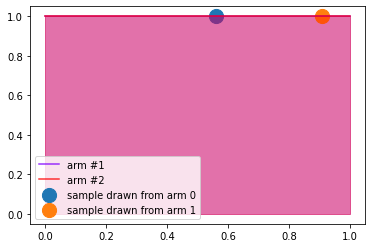

In [20]:
bb.choose_arm_and_plot() #uniform binomials, no observations yet

0

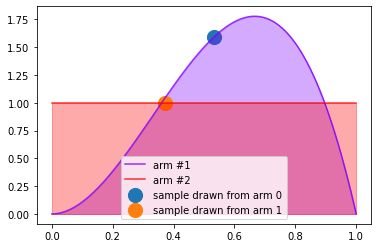

In [24]:
bb.choose_arm_and_plot() #uniform binomials, no observations yet

In [21]:
bb.update(0,0)
bb.update(0,1)
bb.update(0,1)

In [22]:
np.mean([bb.choose_arm() for x in range(100)])

0.39

1

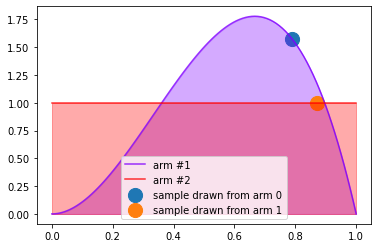

In [23]:
bb.choose_arm_and_plot()

In [25]:
bb.update(1,0)
bb.update(1,0)
bb.update(1,0)

0

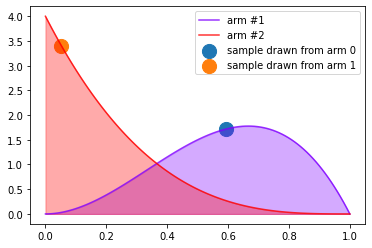

In [26]:
bb.choose_arm_and_plot()